In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# W bosons regressions with a Transformer

## Dataset Loading

In [2]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "jet_padding_mask", "lepton_data", "met_data", "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "jet_padding_mask","lepton_data", "met_data", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=1000000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=500000, device="cuda")

# Create DataLoader
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


## Model definition

Let's start defining a basic transformer with encoder and decoder layers.

In [2]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class MaskedTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward=512):
        super().__init__()
        #https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer
        self.transformer = Transformer(d_model=d_model,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       batch_first = True # Inputs will be [batch, sequence, dim]
                                      )

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        output = self.transformer(src, tgt, 
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask)
        return output


Let's pass to the transformer encode the jets and get out from the Transformer decoder 2 objetcs. 

NB: the number of elements in the decoder is not fixed in the definition of the model.

In [9]:
# Example usage
d_model = 5
nhead = 1
num_encoder_layers = 4
num_decoder_layers = 4

model = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
print(count_parameters(model))
model.to("cuda")

46756


MaskedTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
          

In [8]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs

print(f"Jets shape: {jets.shape}")
# 2 "fake" null tokens to be passed to the decoder
tgt = torch.zeros((batch_size, 2, 5), dtype=torch.float32).to("cuda")

W_out = model(jets, tgt, src_key_padding_mask=jets_mask==0)
W_out.shape

Jets shape: torch.Size([512, 13, 5])


torch.Size([512, 2, 5])

In [7]:
W_out

tensor([[[-0.8211,  1.1226, -0.0428,  1.1016, -1.3602],
         [-0.5332,  1.1715,  0.0032,  0.9317, -1.5733]],

        [[-0.7329,  0.5717, -0.6910,  1.7097, -0.8575],
         [-0.6906,  0.9012, -0.8434,  1.4994, -0.8667]],

        [[ 1.3030, -1.6008,  0.0475, -0.4690,  0.7193],
         [ 0.8541, -1.6160, -0.4423, -0.0055,  1.2097]],

        ...,

        [[-1.2998,  0.9633,  0.0682,  1.2162, -0.9479],
         [-0.1170,  1.3096, -0.2391,  0.6979, -1.6514]],

        [[-1.1111,  0.1510,  0.0327,  1.7505, -0.8231],
         [-1.0906,  0.0930,  0.1033,  1.7494, -0.8550]],

        [[-0.8379,  0.1507, -0.1939,  1.8279, -0.9467],
         [ 0.4048, -0.2095, -0.8310,  1.7142, -1.0785]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

Until now our model makes little sense. We are passing the jets to the Transformer encoder, and then passing empty tensors [Batch, 2, 5] to the Transformer decoder. 

The Transformer decoder manipulate the 2 empty tensors (columns) and using information from the encoder, returns them. 

**Problems**: 
- At the moment the transformer dimension is fixed to the dimension of the last axis of the input --> very limited
- The same for the target.

We need more capacity

### Transformer with projections in an embedded space

In [3]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class WWRegressor(nn.Module):
    
    def __init__(self, 
                 d_model=128, 
                 nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        #Projecting in the transformer embedded
        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model),
            nn.ReLU()
        )

        _layers = [nn.Linear(d_model, regression_net[0]), nn.ReLU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.ReLU())
            
        _layers.append(nn.Linear(regression_net[-1], output_dim))
        self.regression_net = nn.Sequential(*_layers)

    def forward(self, jets, jets_mask):
        emb = self.embedding_jets(jets)

        # NULL token to be passed for decoding
        tgt = torch.zeros((jets.shape[0], 2, self.d_model), 
                          dtype=torch.float32).to("cuda") #--> better to use buffer, see below
        
        out_transf = self.transformer(src=emb, tgt=tgt, src_key_padding_mask=jets_mask)

        out = self.regression_net(out_transf)
        return out
        

In [13]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

model = WWRegressor(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16,16])
model.to("cuda")

WWRegressor(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-3): 4 x

In [12]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
W_out = model(jets, jets_mask==0)
W_out.shape

torch.Size([512, 2, 4])

In [12]:
W_out

tensor([[[ 0.1286, -0.3454,  0.1123, -0.0353],
         [ 0.0130, -0.3706,  0.0544, -0.1228]],

        [[ 0.1705, -0.1802,  0.1010,  0.0210],
         [ 0.1415, -0.2674,  0.1315, -0.0402]],

        [[ 0.1556, -0.2411,  0.0442, -0.0376],
         [ 0.0508, -0.2535, -0.0252, -0.1139]],

        ...,

        [[ 0.1233, -0.2834,  0.0140, -0.0669],
         [ 0.1182, -0.3467, -0.0357, -0.1191]],

        [[ 0.0763, -0.3486,  0.0679, -0.0531],
         [ 0.0540, -0.4217,  0.0188, -0.1290]],

        [[ 0.1064, -0.2920,  0.0020, -0.0028],
         [ 0.1909, -0.2603,  0.1056,  0.0516]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

The numbers are still nonsense of course, we haven't trained the model. But now the shapes are handled correctly. 
We need now to add also the leptons and met to the inputs. 

### Adding leptons and MET to the inputs
Leptons and MET need a different embedding network to make the dimensions of the input tensors to the transformer the same

In [15]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=500000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

In [5]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1, 1), dtype=torch.float32)
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

class WWRegressorComplete(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )
        
        _layers = [nn.Linear(d_model, regression_net[0]), nn.SELU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(regression_net[-1], output_dim))
        self.regression_net = nn.Sequential(*_layers)

        # Technicality: temporary objects, not parameters
        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        self.register_buffer("decoder_null_tokens", torch.zeros((2, self.d_model), dtype=torch.float32))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)# [B, T1, F] concat axis1 [B, T2, F]
        emb = torch.cat([emb, labels], dim=-1)# [B, T, F1] concat axis2 [B, T, F2]

        # expanding the mask for lepton and met
        tgt = self.decoder_null_tokens.expand(batch_size, *list(self.decoder_null_tokens.shape))
        out_transf = self.transformer(src=emb, tgt=tgt, src_key_padding_mask=full_mask)

        out = self.regression_net(out_transf)
        return out
        

In [6]:
# Example usage
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressorComplete(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0

In [44]:
inputs = next(iter(dataloader_train))
jets, lepton, met, full_mask, nu, W = inputs
W_out = model(jets, lepton, met, full_mask==0)
W_out.shape

torch.Size([1024, 2, 4])

## Training Loop

In [7]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

Let's have a function plotting some validation plots for the regressed Ws

In [8]:
def validation_plots(W, W_out):
    f1 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist2d(W[:,i, j].cpu().numpy(), W_out[:,i, j].cpu().numpy(),
              bins=60, range=((-3,3),(-3,3)),
            norm=LogNorm())
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

    f2 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist(W[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Target", histtype="step")
            axs[i][j].hist(W_out[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Regressed", histtype="step")
            axs[i][j].legend()
            if j == 0:
                axs[i][j].set_xlabel("pt")
            elif j == 1:
                axs[i][j].set_xlabel("eta")
            elif j == 2:
                axs[i][j].set_xlabel("phi")
            elif j == 3:
                axs[i][j].set_xlabel("mass")

    f3 , axs = plt.subplots(1, 4, figsize=(16, 5))
    for j in range(4):
        axs[j].hist2d(W_out[:,0, j].cpu().numpy()-W[:,0,j].cpu().numpy(),
                      W_out[:,1, j].cpu().numpy()-W[:,1,j].cpu().numpy(),
                    bins=80, range=((-2,2),(-2,2)), 
                    norm=LogNorm())
        if j == 0:
            axs[j].set_xlabel("Delta pt W1")
            axs[j].set_ylabel("Delta pt W2")
        elif j == 1:
            axs[j].set_xlabel("Delta eta W1")
            axs[j].set_ylabel("Delta eta W2")
        elif j == 2:
            axs[j].set_xlabel("Delta phi W1")
            axs[j].set_ylabel("Delta phi W1")
        elif j == 3:
            axs[j].set_xlabel("Delta mass W1")
            axs[j].set_ylabel("Delta mass W2")

    f4 , axs = plt.subplots(1, 4, figsize=(16, 5))
    for j in range(4):
        axs[j].hist2d(W_out[:,0, j].cpu().numpy(),W_out[:,1,j].cpu().numpy(),
                    bins=80, range=((-2,2),(-2,2)), 
                    norm=LogNorm())
        if j == 0:
            axs[j].set_xlabel("Regressed 1 pt")
            axs[j].set_ylabel("Regressed 2 pt")
        elif j == 1:
            axs[j].set_xlabel("Regressed 1 eta")
            axs[j].set_ylabel("Regressed 2 eta")
        elif j == 2:
            axs[j].set_xlabel("Regressed 1 phi")
            axs[j].set_ylabel("Regressed 2 phi")
        elif j == 3:
            axs[j].set_xlabel("Regressed 1 mass")
            axs[j].set_ylabel("Regressed 2 mass")

    f5 , axs = plt.subplots(1, 4, figsize=(16, 5))
    for j in range(4):
        axs[j].hist2d(W[:,0, j].cpu().numpy(),W[:,1,j].cpu().numpy(),
                    bins=80, range=((-2,2),(-2,2)), 
                    norm=LogNorm())
        if j == 0:
            axs[j].set_xlabel("Target 1 pt")
            axs[j].set_ylabel("Target 2 pt")
        elif j == 1:
            axs[j].set_xlabel("Target 1 eta")
            axs[j].set_ylabel("Target 2 eta")
        elif j == 2:
            axs[j].set_xlabel("Target 1 phi")
            axs[j].set_ylabel("Target 2 phi")
        elif j == 3:
            axs[j].set_xlabel("Target 1 mass")
            axs[j].set_ylabel("Target 2 mass")


    return f1,f2, f3, f4, f5

In [11]:
def train(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            # we need to convert the padding mask in the format pytorch expects
            # full_mask  ==0 --> put True to the masked value. 
    
            loss = criterion(W_out, W).mean() #[B, T, F]
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss}")
                
            loss.backward()
            optimizer.step()
        
        # Validation loss
        model.eval()
        val_loss = 0.  
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val,full_mask_val==0)
                loss = criterion(W_out_val, W_val)
                val_loss += loss.nanmean().item()
            
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
            val_loss = val_loss / len(val_loader)
            
            print(f"epoch {epoch}, validation loss: {val_loss}")
        print("End of epoch")
    return model

In [12]:
num_epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='none')

trained_model = train(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 1.356135368347168
epoch 0, step 100, Loss: 0.8333901166915894
epoch 0, step 200, Loss: 0.7720069885253906
epoch 0, step 300, Loss: 0.8151302337646484
epoch 0, validation loss: 0.751843948662281
End of epoch
epoch 1, step 0, Loss: 0.7500256299972534
epoch 1, step 100, Loss: 0.7745237946510315
epoch 1, step 200, Loss: 0.7451298236846924
epoch 1, step 300, Loss: 0.80130934715271
epoch 1, validation loss: 0.7415450930595398
End of epoch
epoch 2, step 0, Loss: 0.7432296276092529
epoch 2, step 100, Loss: 0.7626173496246338
epoch 2, step 200, Loss: 0.7327207326889038
epoch 2, step 300, Loss: 0.7933765649795532
epoch 2, validation loss: 0.7363727673888206
End of epoch
epoch 3, step 0, Loss: 0.7359551787376404
epoch 3, step 100, Loss: 0.7559112310409546
epoch 3, step 200, Loss: 0.725548505783081
epoch 3, step 300, Loss: 0.7869685888290405
epoch 3, validation loss: 0.7335769444704056
End of epoch
epoch 4, step 0, Loss: 0.7307850122451782
epoch 

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>)

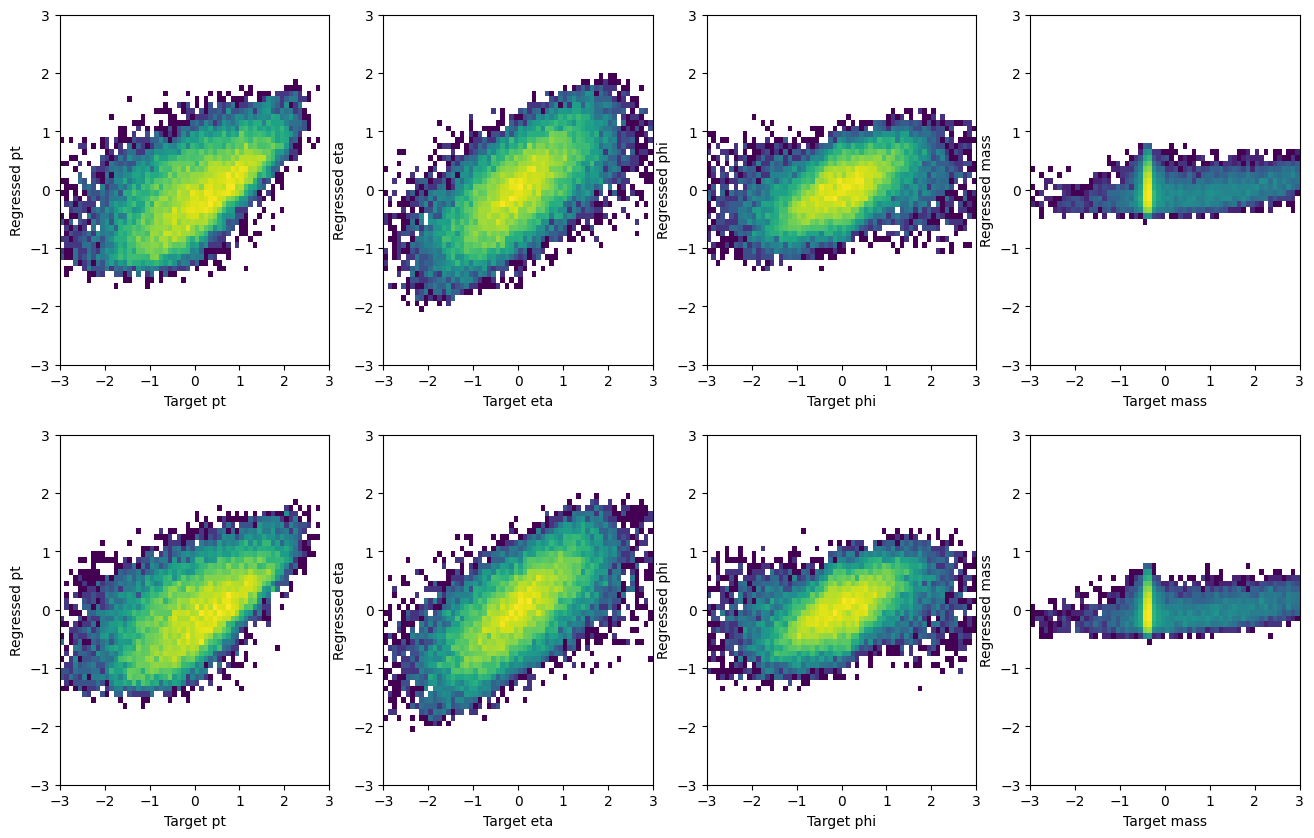

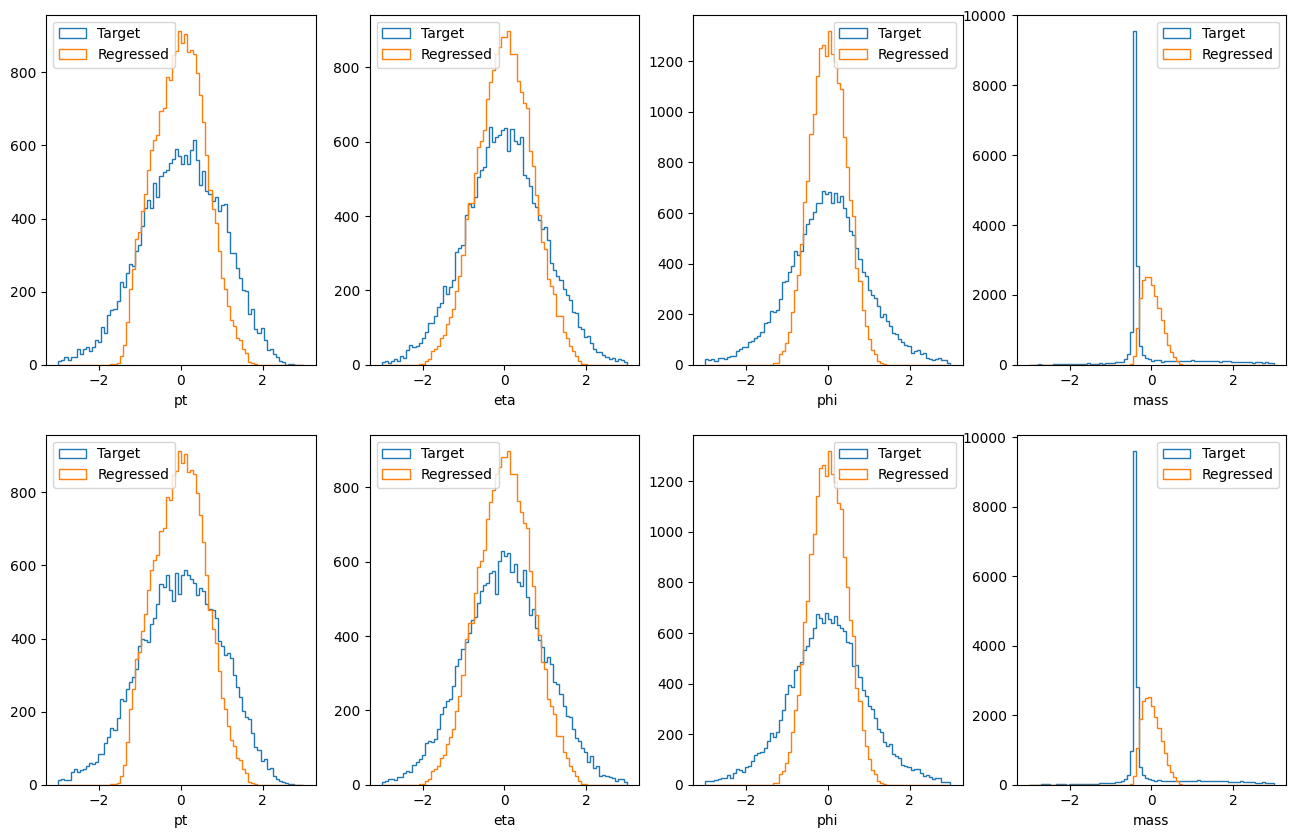

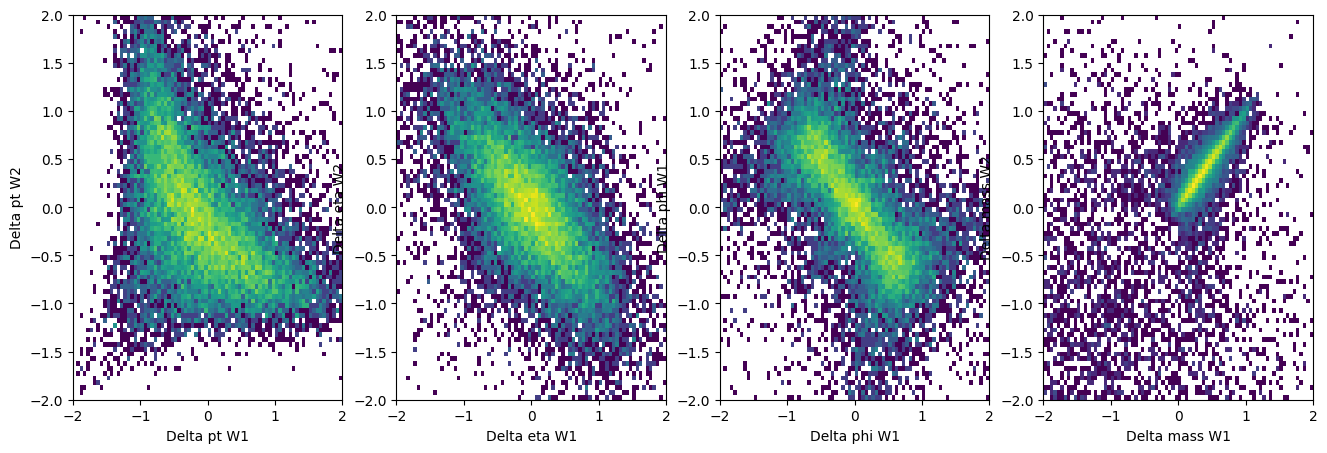

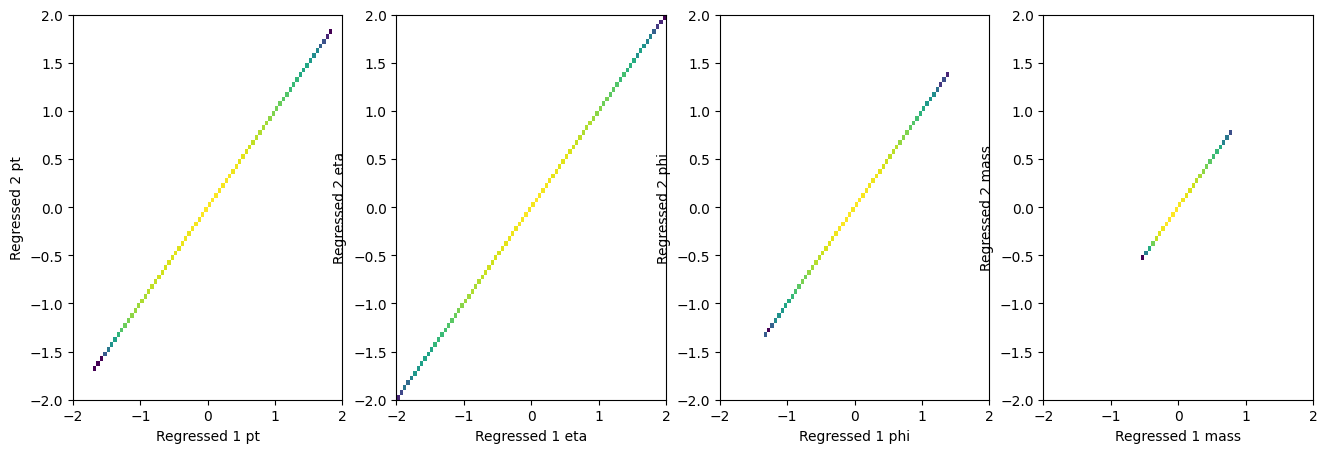

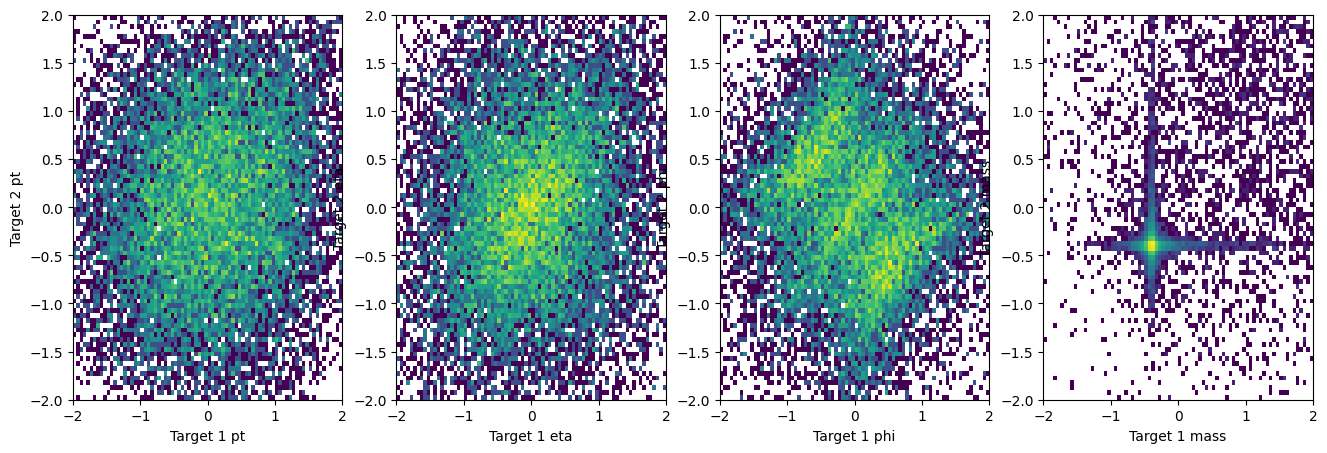

In [13]:
#Larger evaluation
model.eval()
with torch.no_grad():
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask==0)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

In [14]:
torch.save(model.state_dict(), "models/model_WWregr_initial.pt")

## Problem

Looking at the validation plot, for each W boson, we are starting to regress it correctly for some event. But we are always regressing two identical W boson!

This means that for some events we regress correctly 1 boson and for others the other boson. 

This is explained by the fact that we are passing two identical null tokens to the transformers to decode the W boson. There is not way for the transformer to associate each token correctly to the correct W boson. 

It is not enough to just change the value of the 2 NUll tokens, we need to have a **consistent ordering** in the target W boson vector. In this way the transformer can "break the symmetry" and  start to learn two different 4 momenta. 

We ordered the W boson by eta and saved a new trainin dataset called "W_ordered_data".

In [18]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1, 1), dtype=torch.float32)
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

class WWRegressorWOrdered(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )
        
        _layers = [nn.Linear(d_model, regression_net[0]), nn.SELU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(regression_net[-1], output_dim))
        self.regression_net = nn.Sequential(*_layers)

        # Technicality: temporary objects, not parameters
        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        self.register_buffer("decoder_null_tokens", torch.zeros((2, self.d_model), dtype=torch.float32))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)# [B, T1, F] concat axis1 [B, T2, F]
        emb = torch.cat([emb, labels], dim=-1)# [B, T, F1] concat axis2 [B, T, F2]

        # expanding the mask for lepton and met
        tgt = self.decoder_null_tokens.expand(batch_size, *list(self.decoder_null_tokens.shape))
        # Let's differentiate the null tokens to create an ordering
        tgt[:,1] = 1 
        out_transf = self.transformer(src=emb, tgt=tgt, src_key_padding_mask=full_mask)
        out = self.regression_net(out_transf)
        return out
        

In [19]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# NOTE THE NEW W_Data sample
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_ordered_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_ordered_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

In [20]:
num_epochs = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorWOrdered(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='none')

trained_model = train(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 1.1020605564117432
epoch 0, step 100, Loss: 0.789594829082489
epoch 0, step 200, Loss: 0.7027137279510498
epoch 0, step 300, Loss: 0.7320646047592163
epoch 0, validation loss: 0.6398069515824318
End of epoch
epoch 1, step 0, Loss: 0.6522396802902222
epoch 1, step 100, Loss: 0.6595425605773926
epoch 1, step 200, Loss: 0.6265779733657837
epoch 1, step 300, Loss: 0.6760661602020264
epoch 1, validation loss: 0.5993336170911789
End of epoch
epoch 2, step 0, Loss: 0.6065918207168579
epoch 2, step 100, Loss: 0.6371979117393494
epoch 2, step 200, Loss: 0.6124427318572998
epoch 2, step 300, Loss: 0.6587228178977966
epoch 2, validation loss: 0.589302308857441
End of epoch
epoch 3, step 0, Loss: 0.595772385597229
epoch 3, step 100, Loss: 0.621224045753479
epoch 3, step 200, Loss: 0.6014013290405273
epoch 3, step 300, Loss: 0.6436605453491211
epoch 3, validation loss: 0.5835686981678009
End of epoch
epoch 4, step 0, Loss: 0.5886701345443726
epoch

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>)

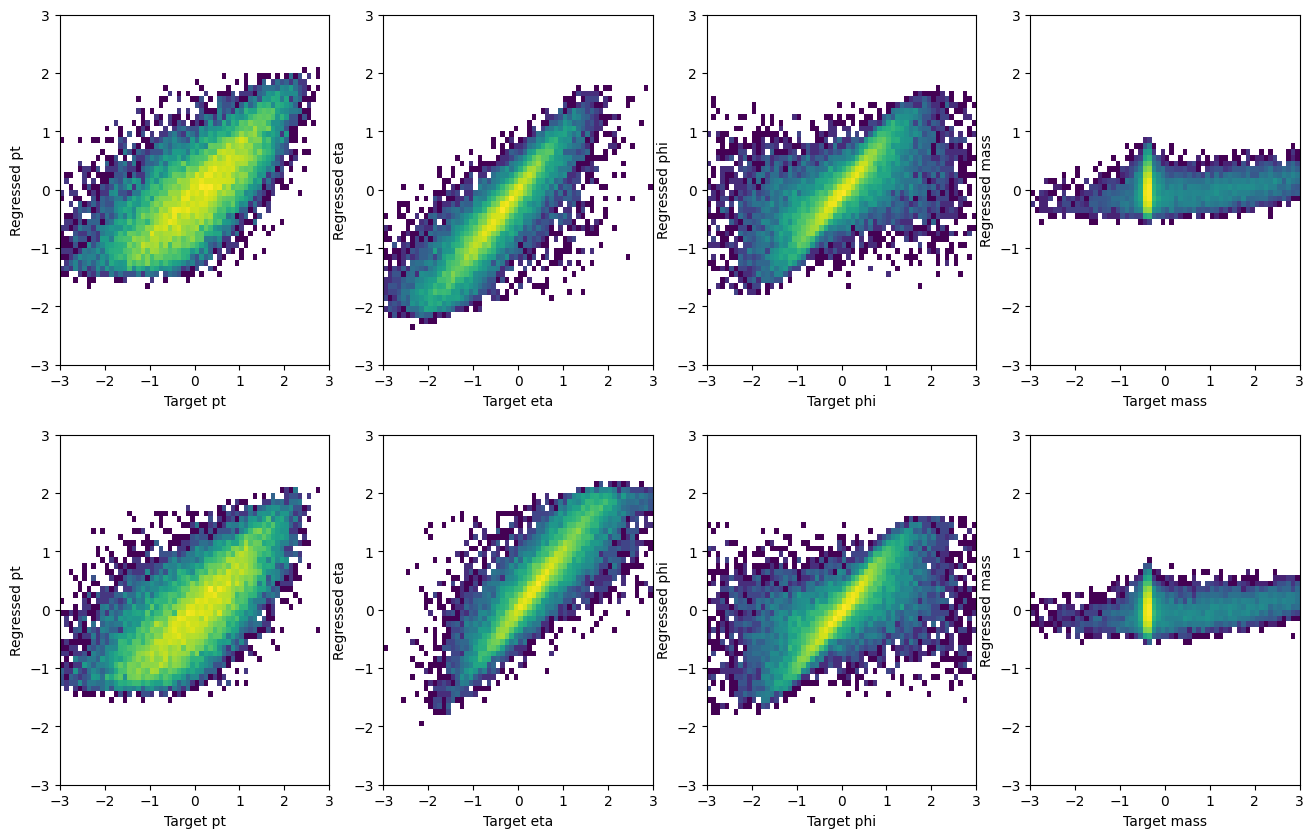

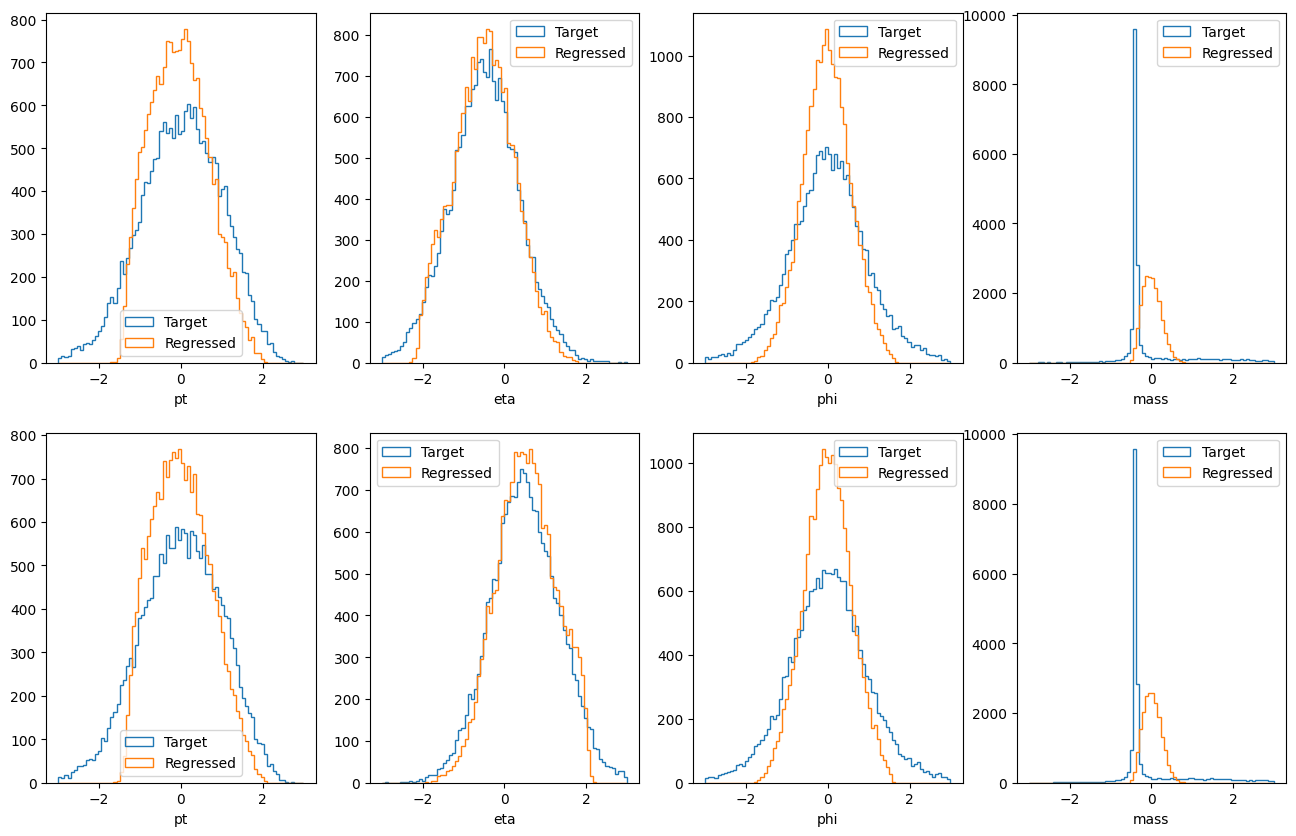

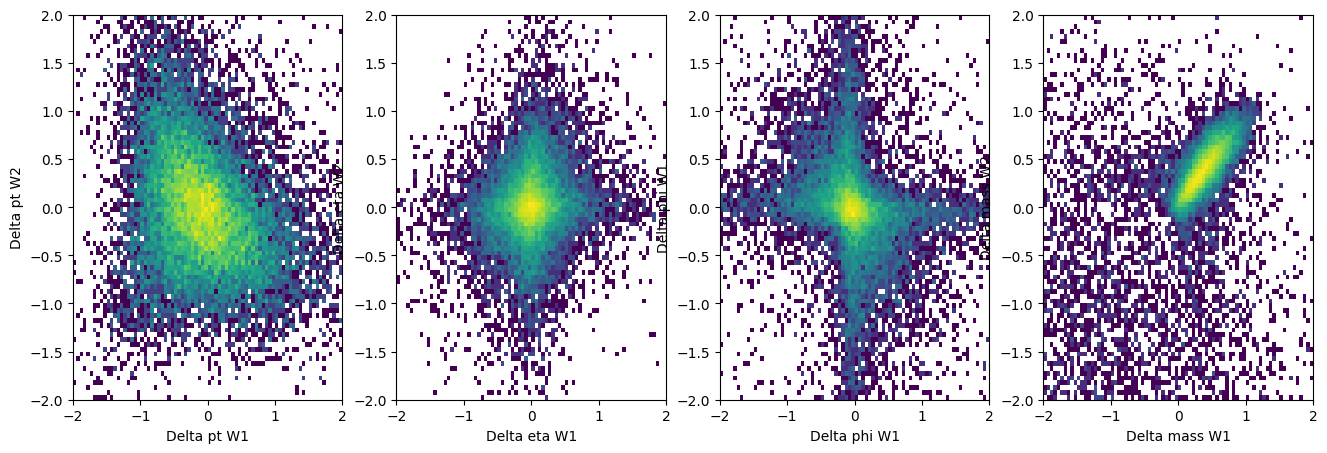

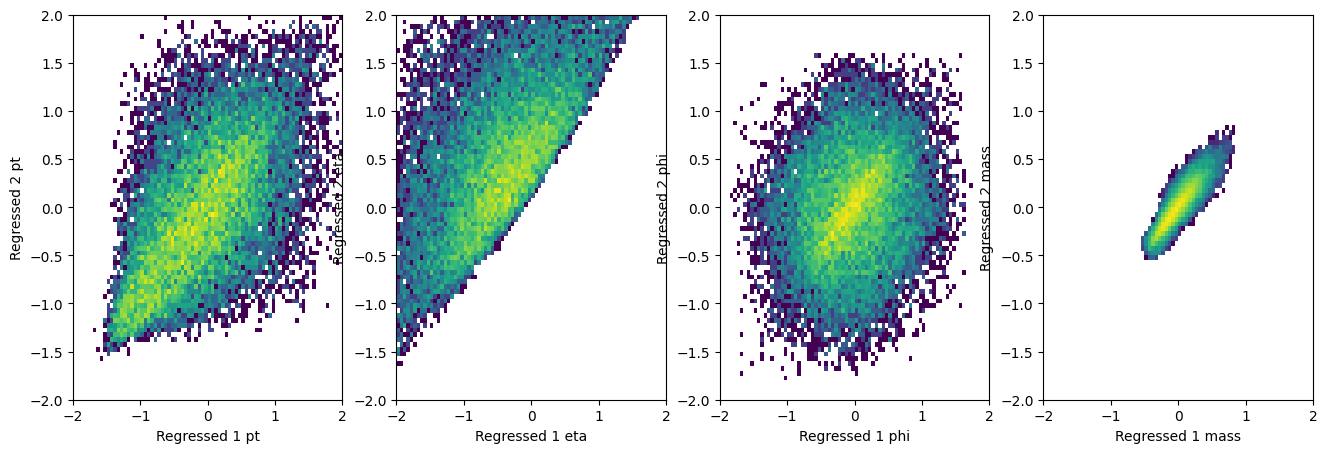

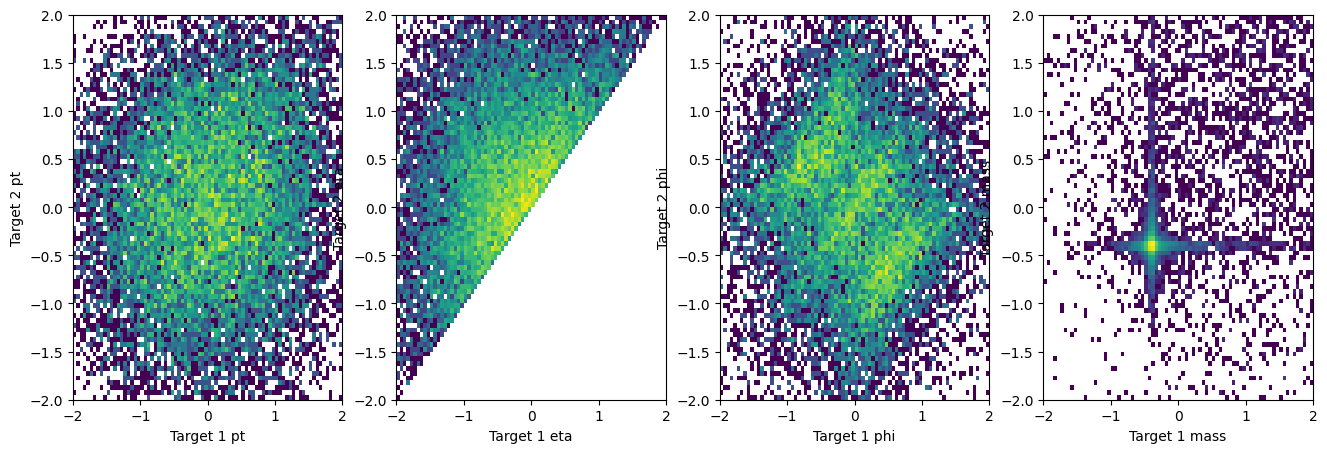

In [21]:
#Larger evaluation
model.eval()
with torch.no_grad():
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask==0)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

## Training with MMD loss

Often regressions are biased toward the most probable value. This is a "feature" of the MSE loss.
If the value to regress is not "flat" but has long tails, the regression will often collpapse on the most probable case.

Using an alternative regression loss such as the **Huber loss** [wikipedia](https://en.wikipedia.org/wiki/Huber_loss) can alleviate the problem, but not solve it completely. 

To counteract this problem we can add to the loss a term that is measuring the difference between the distribution of the target variable and the distribution of the output of the regression./



In [22]:
from libs.mmd import MMD

In [23]:
torch.cuda.empty_cache()

In [24]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_ordered_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_ordered_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

In [25]:
def train_withMMD(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out, W).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                  
            loss.backward()
            optimizer.step()
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val, W_val).nanmean()
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [26]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorWOrdered(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')

exp = None

trained_model = train_withMMD(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 3.3773, loss regr: 1.0941,  MMD W1: 1.1571, MMD W2: 1.1261 
epoch 0, step 100, Loss: 1.4209, loss regr: 1.0973,  MMD W1: 0.1605, MMD W2: 0.1631 
epoch 0, step 200, Loss: 1.0550, loss regr: 0.8539,  MMD W1: 0.0999, MMD W2: 0.1012 
epoch 0, step 300, Loss: 1.0542, loss regr: 0.8664,  MMD W1: 0.0937, MMD W2: 0.0940 
epoch 0, Validation Loss: 0.9302, loss regr: 0.7970,  MMD W1: 0.0693, MMD W2: 0.0639 
End of epoch 0
epoch 1, step 0, Loss: 0.9169, loss regr: 0.7785,  MMD W1: 0.0716, MMD W2: 0.0668 
epoch 1, step 100, Loss: 0.9061, loss regr: 0.8071,  MMD W1: 0.0478, MMD W2: 0.0513 
epoch 1, step 200, Loss: 0.8426, loss regr: 0.7603,  MMD W1: 0.0402, MMD W2: 0.0421 
epoch 1, step 300, Loss: 0.8936, loss regr: 0.8149,  MMD W1: 0.0382, MMD W2: 0.0405 
epoch 1, Validation Loss: 0.8270, loss regr: 0.7631,  MMD W1: 0.0326, MMD W2: 0.0313 
End of epoch 1
epoch 2, step 0, Loss: 0.8127, loss regr: 0.7455,  MMD W1: 0.0356, MMD W2: 0.0316 
epoch 2, s

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>)

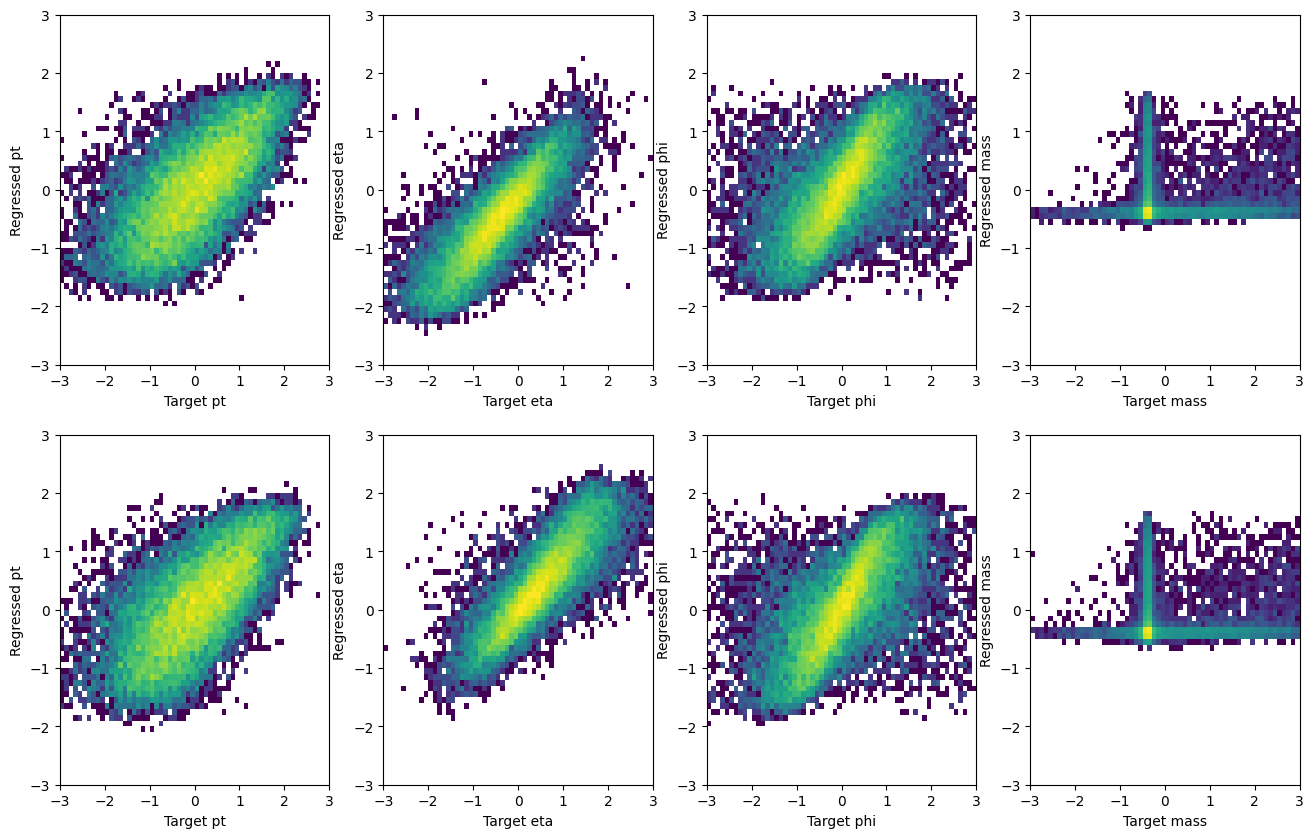

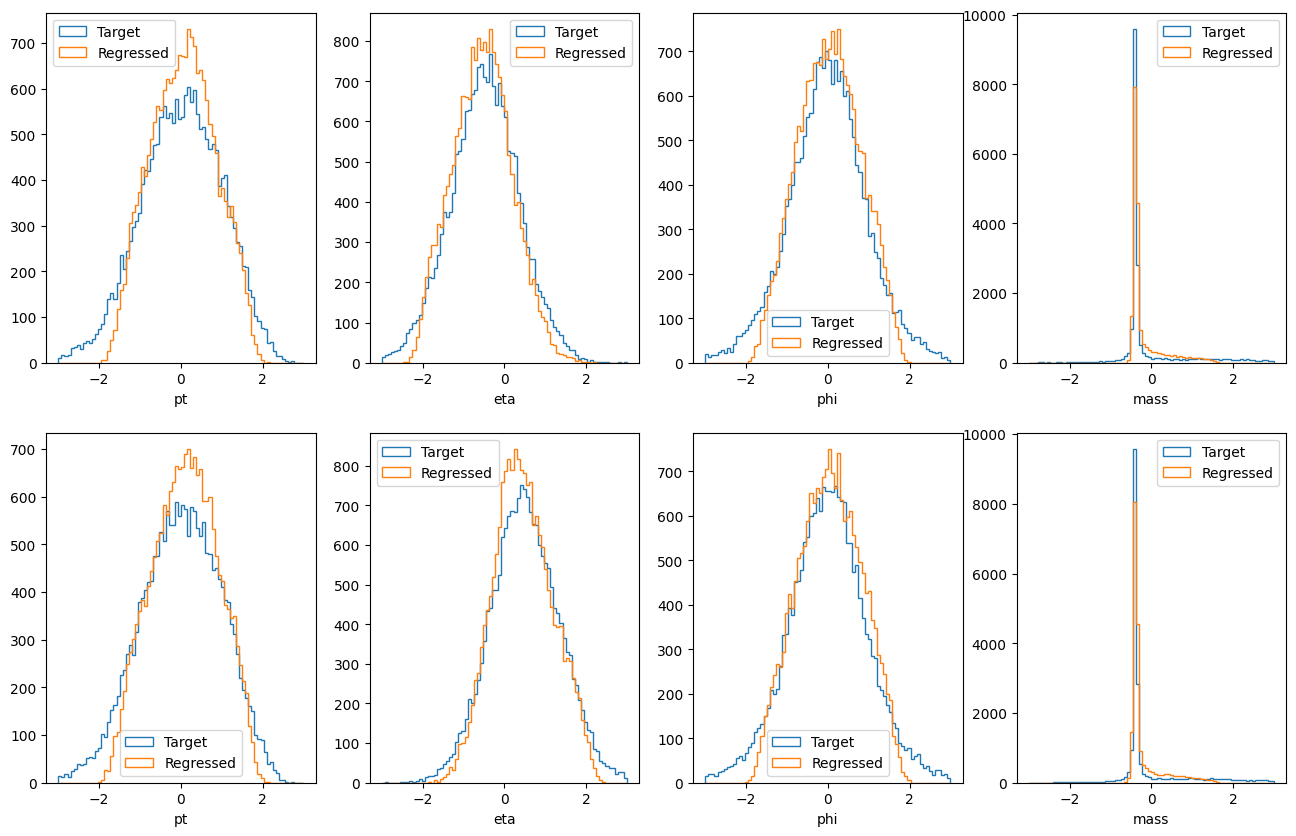

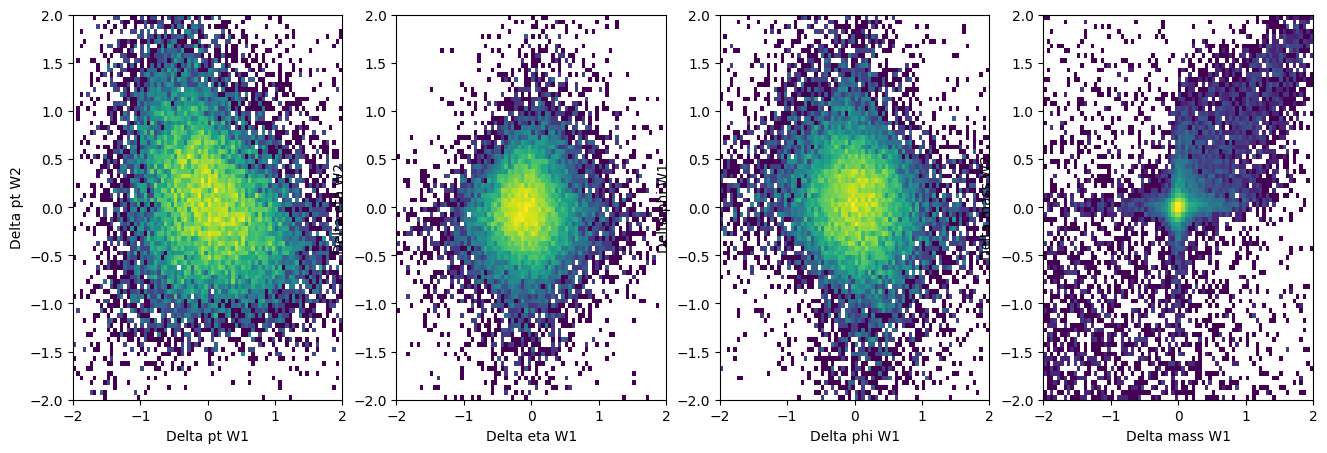

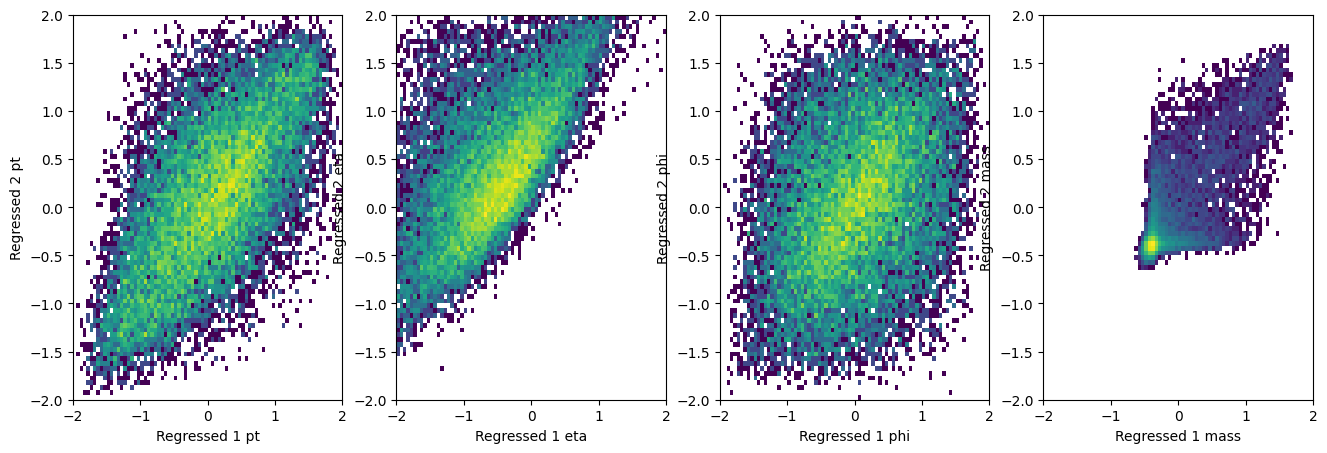

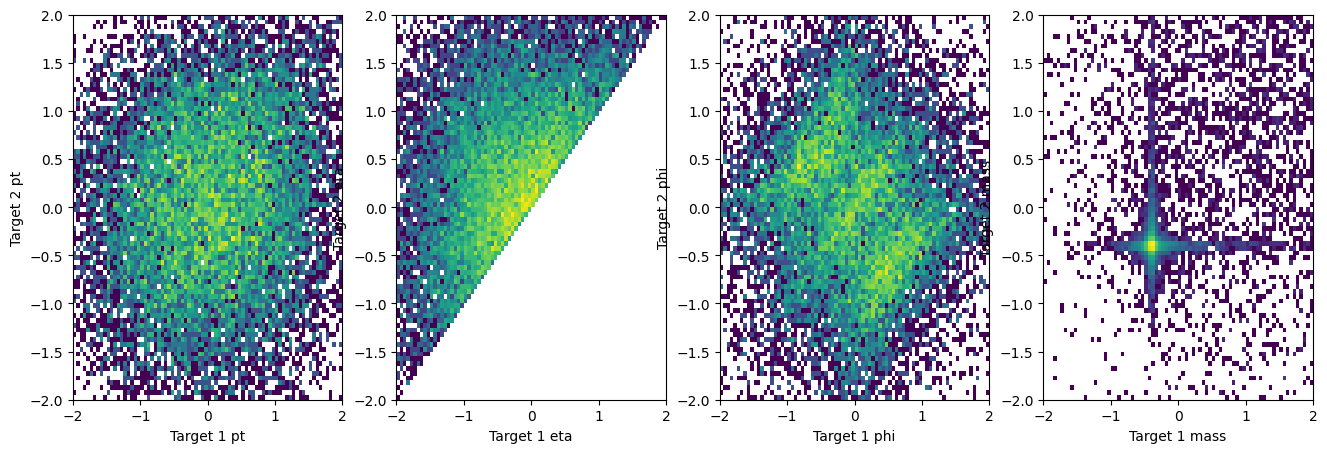

In [27]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

In [28]:
torch.save(model.state_dict(), "models/model_WWregr_mmdloss.pt")

## Periodic-phi loss

The MSE or Huber loss for the phi variable is not taking into account the intrinsic periodicity of the phi variable. 
To take take into account we have to rescale the phi feature to the original [-pi, pi] space, and take the distance between the target and the regressed phi considering the periodicity. 

In [29]:
def logistic(x):
    return 1/(1+torch.exp(-x))

def logit(x, clip=1e-6):
    x = np.clip(x, a_min=clip, a_max=1-clip)
    return np.log(x/(1-x))

In [39]:
phi_scaling = torch.from_numpy(np.load(f"{datafolder}/W_data_scaling.npy")[2]).to("cuda")

def unscale_phi(phi):
    return  logistic((phi * phi_scaling[1])+phi_scaling[0])* 2 *np.pi - np.pi

def phi_loss(phi_x, phi_y, loss_fn):
    unscaled_x = unscale_phi(phi_x)
    unscaled_y = unscale_phi(phi_y)
    deltaPhi = unscaled_x - unscaled_y
    deltaPhi = torch.where(deltaPhi > np.pi, deltaPhi - 2*np.pi, deltaPhi)
    deltaPhi = torch.where(deltaPhi <= -np.pi, deltaPhi + 2*np.pi, deltaPhi)
    return (deltaPhi)**2

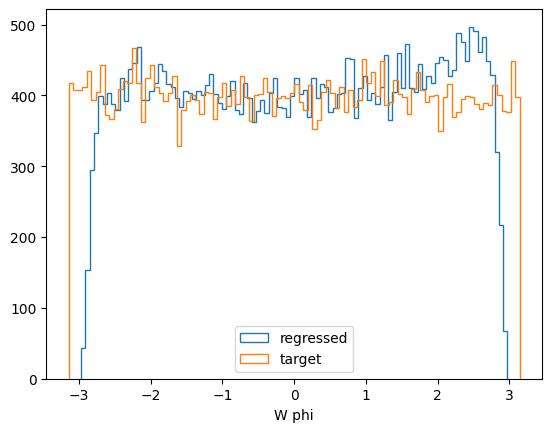

In [31]:
plt.hist(unscale_phi(W_out[:,:,2]).cpu().flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2].cpu().flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

In [32]:
def train_withMMD_philoss(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out[:,:,0:2], W[:,:,0:2]).nanmean() +\
                         criterion(W_out[:,:,3], W[:,:,3]).nanmean() + \
                         phi_loss(W_out[:,:,2], W[:,:,2], criterion).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                    
            loss.backward()
            optimizer.step()
        # Log metrics
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val[:,:,0:2], W_val[:,:,0:2]).nanmean() +\
                         criterion(W_out_val[:,:,3], W_val[:,:,3]).nanmean() + \
                         phi_loss(W_out_val[:,:,2], W_val[:,:,2], criterion).nanmean()

                
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [42]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 3e-4

model = WWRegressorWOrdered(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')

trained_model = train_withMMD_philoss(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 236279 parameters
epoch 0, step 0, Loss: 7.9937, loss regr: 5.6754,  MMD W1: 1.1249, MMD W2: 1.1933 
epoch 0, step 100, Loss: 3.8844, loss regr: 3.7129,  MMD W1: 0.0855, MMD W2: 0.0860 
epoch 0, step 200, Loss: 3.5407, loss regr: 3.4358,  MMD W1: 0.0481, MMD W2: 0.0567 
epoch 0, step 300, Loss: 3.3519, loss regr: 3.2331,  MMD W1: 0.0613, MMD W2: 0.0574 
epoch 0, Validation Loss: 3.0180, loss regr: 2.8979,  MMD W1: 0.0584, MMD W2: 0.0617 
End of epoch 0
epoch 1, step 0, Loss: 2.9881, loss regr: 2.8650,  MMD W1: 0.0590, MMD W2: 0.0641 
epoch 1, step 100, Loss: 2.7639, loss regr: 2.6668,  MMD W1: 0.0455, MMD W2: 0.0516 
epoch 1, step 200, Loss: 2.8977, loss regr: 2.8067,  MMD W1: 0.0423, MMD W2: 0.0488 
epoch 1, step 300, Loss: 2.6326, loss regr: 2.5318,  MMD W1: 0.0454, MMD W2: 0.0554 
epoch 1, Validation Loss: 2.6403, loss regr: 2.5457,  MMD W1: 0.0461, MMD W2: 0.0486 
End of epoch 1
epoch 2, step 0, Loss: 2.6145, loss regr: 2.5155,  MMD W1: 0.0483, MMD W2: 0.0507 
epoch 2, s

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>)

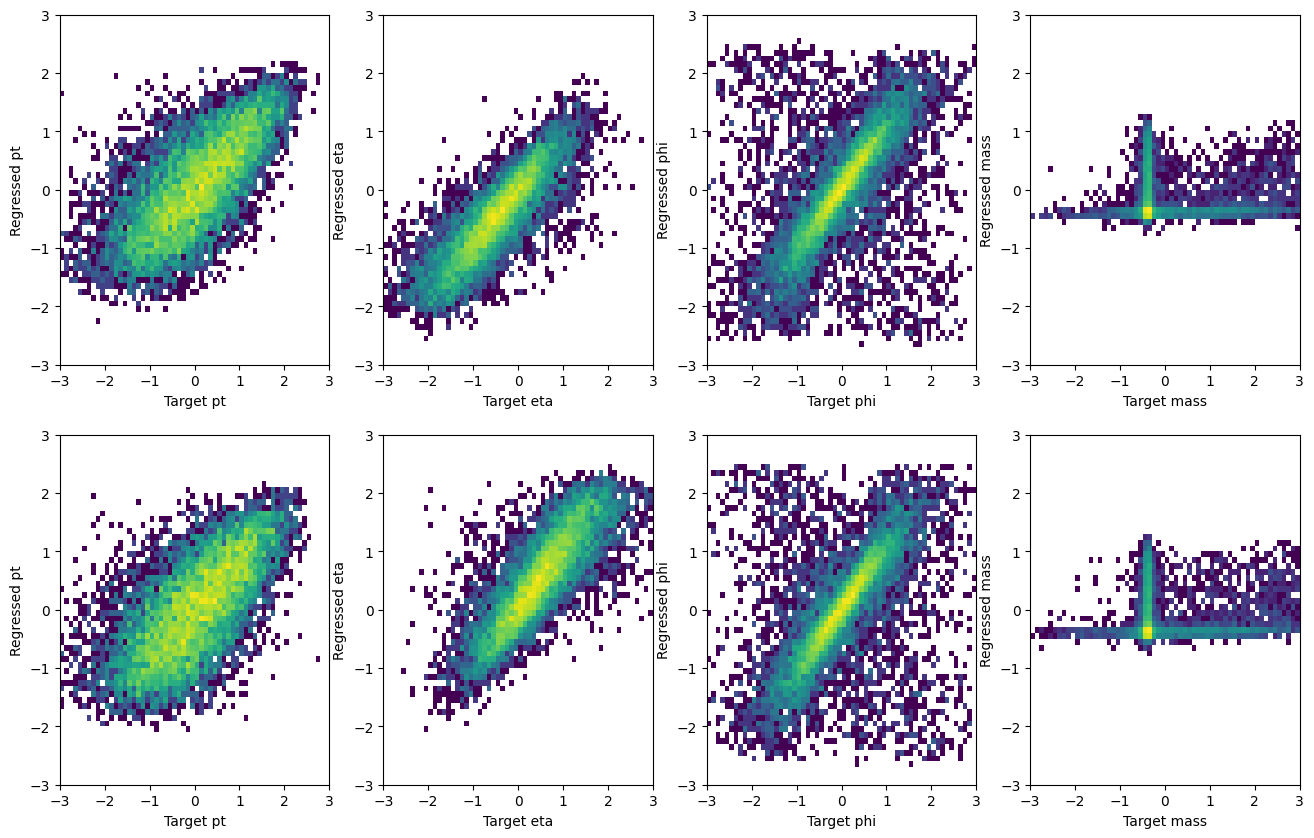

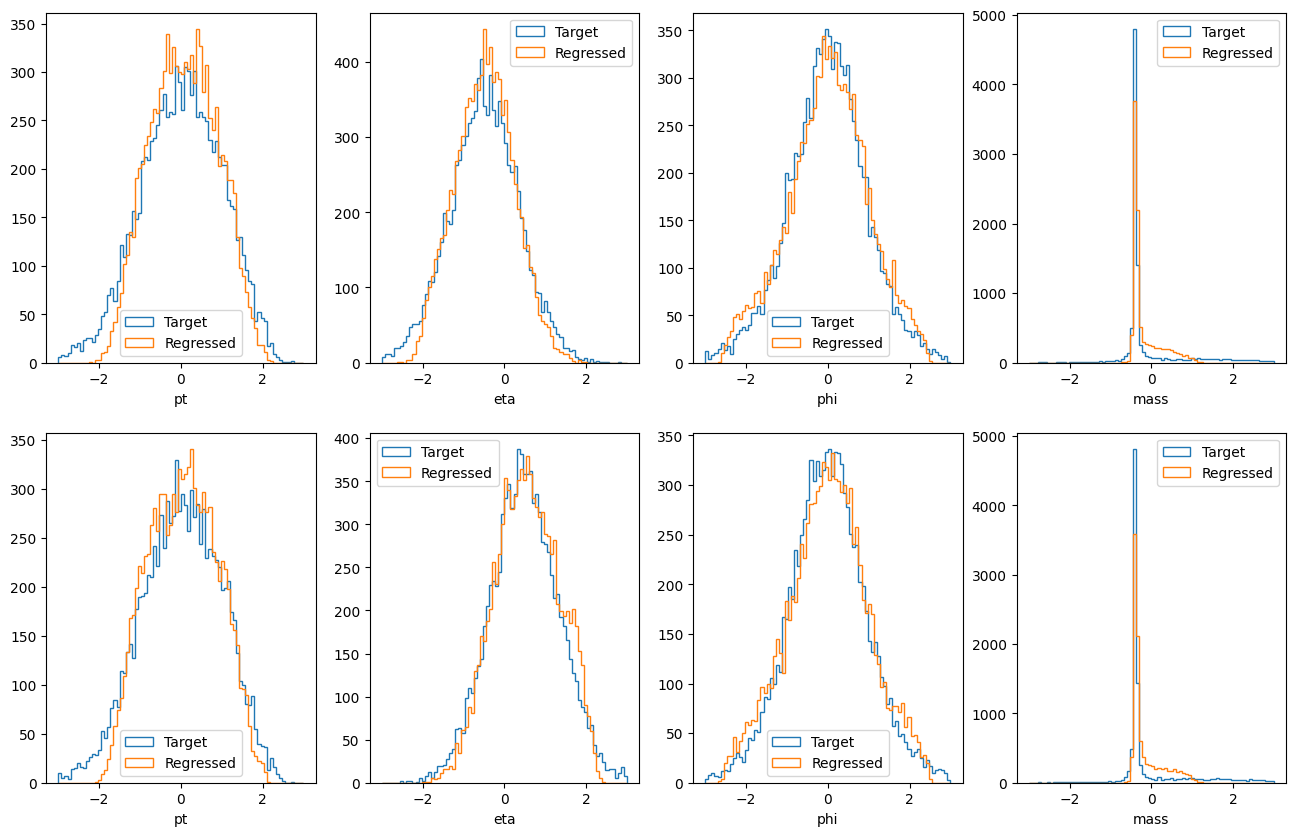

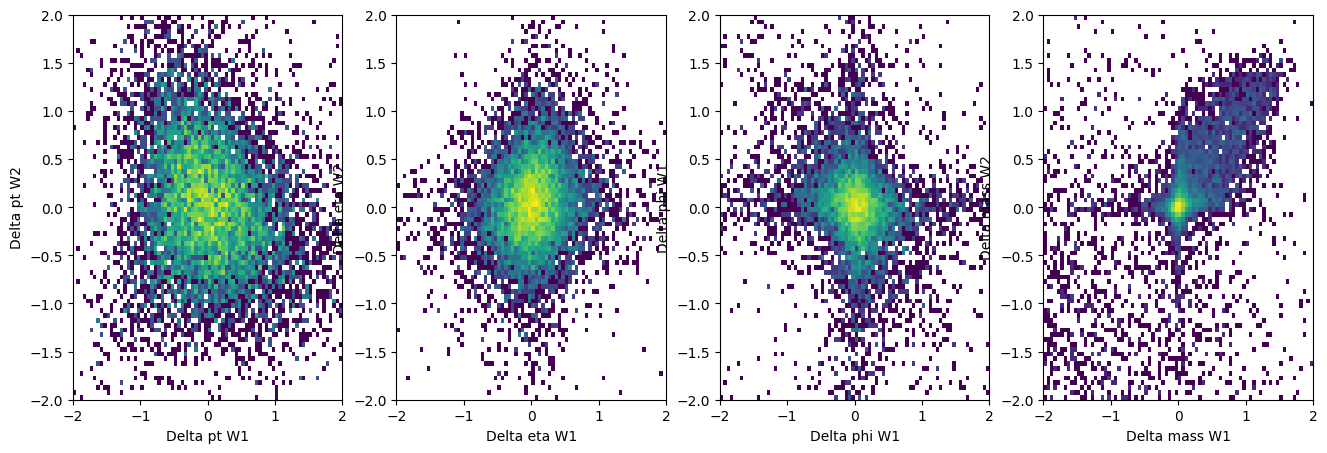

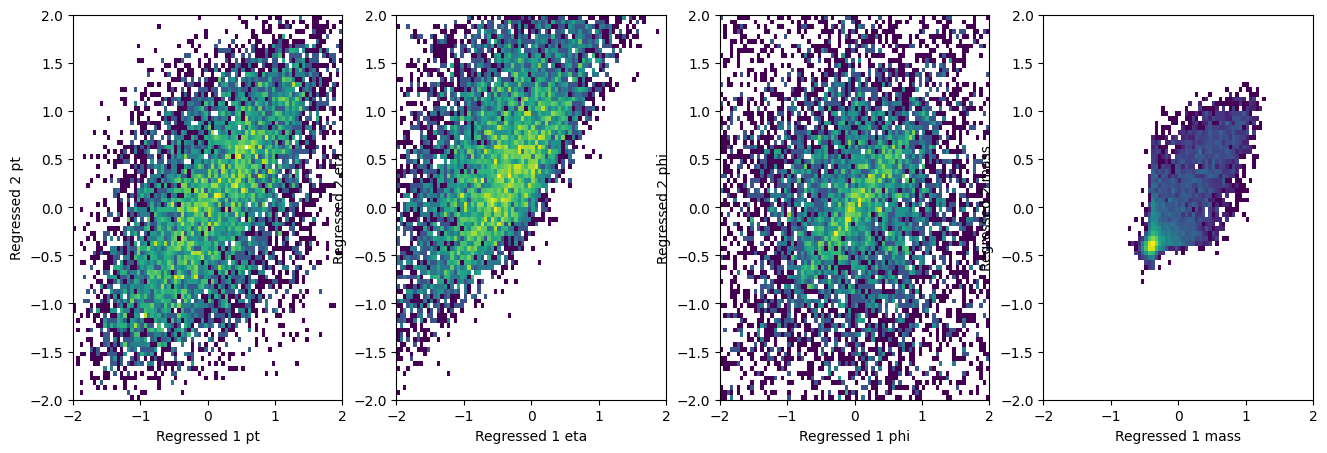

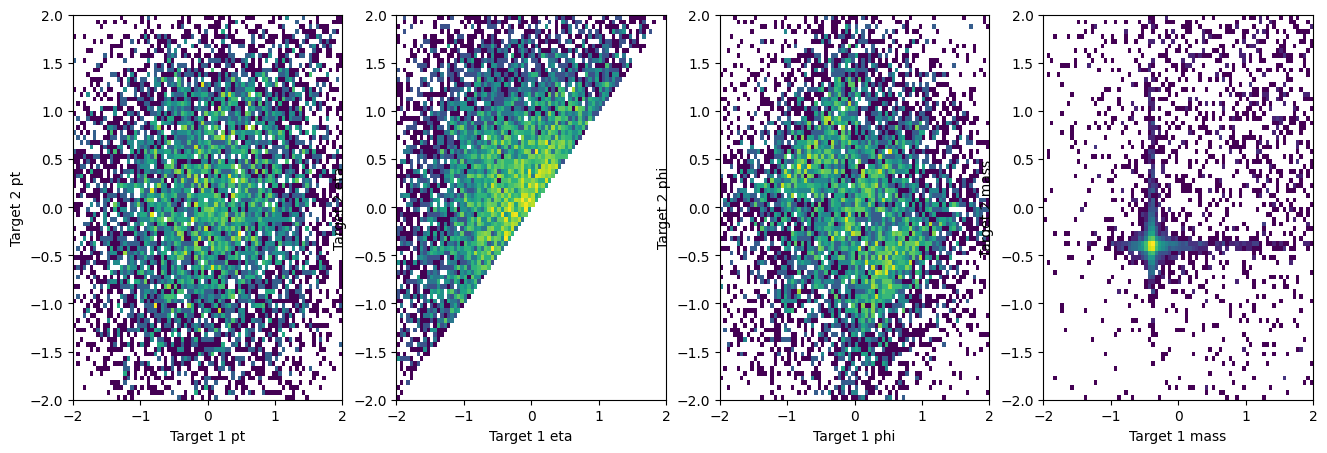

In [43]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:10000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

Including the phi periodicity loss improved event more the performance.

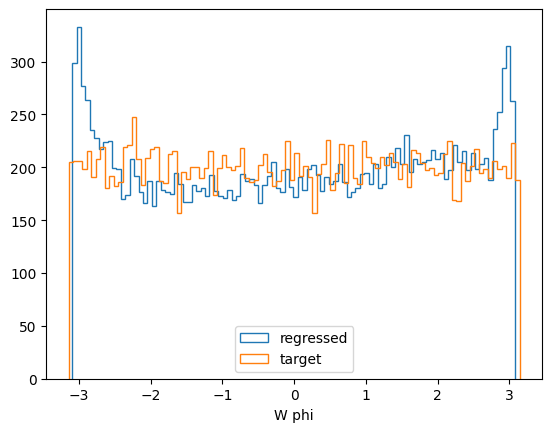

In [45]:
plt.hist(unscale_phi(W_out[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

The problem with the phi extremes is disappeared, and it is now kind of in the other direction. Too many events 
close to the boundary.

In [46]:
torch.save(model.state_dict(), "models/model_wwregress_mmd_phiperiodic.pt")

# Constrained optimization

We would like to have an even lower value of the MMD loss to fully match the distributions of the target W bosons. 
The problem is that the scale of the MMD loss is now much lower than the value of the regression loss. 
The optimizer won't focus on the MMD loss at this level in the numerial optimization of the loss. 

In order to constraint the distribution even more we should give more weight to the MMD loss. A common solution is to just increase the *relative weight* of the MMD loss in the total loss: 
$$ loss = loss_{regr} + \lambda \cdot loss_{MMD}$$.

This solution is usually fine, but optimizing for the best value of $\lambda$ can be problematic (see slides). 

A more stable and consistent solution is using the *Modified Differential Multiplier Method* (mdmm) [article](https://www.engraved.blog/how-we-can-make-machine-learning-algorithms-tunable/). See slides for full explanation.


In [47]:
def compute_MMD_loss(W_x, W_y):
    mmds = []
    for p in range(2):
        for i in range(4):
            mmds.append(MMD(W_y[:,p,i:i+1], W_x[:,p,i:i+1], kernel="multiscale", device=W_x.device, dtype=W_x.dtype))
    return sum(mmds)/8

def compute_regr_loss(W_x, W_y, loss_fn):
    return loss_fn(W_x[:,:,0:2], W_y[:,:,0:2]).nanmean() +\
                 loss_fn(W_x[:,:,3], W_y[:,:,3]).nanmean() + \
                 phi_loss(W_x[:,:,2], W_y[:,:,2], loss_fn).nanmean()
    

In [48]:
def train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            mask_notnan = ~mask_nan

            loss_regr = compute_regr_loss(W_out, W, criterion)
            # Now using MDMM for the MMD loss
            mdmm_return = MDMM_module(loss_regr, [(W_out[mask_notnan], W[mask_notnan])])
            # Using the output of the MDMM module as the total loss to optimize --> this includes the modified constraint terms
            loss = mdmm_return.value
            # Getting the MDMM value anyway to log it 
            MMD_loss = compute_MMD_loss(W_out[mask_notnan], W[mask_notnan])
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_regr.item():.4f},  MMD total: {MMD_loss.item():.4f} ")
                 
            loss.backward()
            optimizer.step()
            
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_regr = 0.
        val_loss_mmd = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                mask_notnan_val = ~mask_nan_val
                MMD_loss_val = compute_MMD_loss(W_out_val[mask_notnan_val], W_val[mask_notnan_val])
                
                loss_regr_val = compute_regr_loss(W_out_val, W_val, criterion)
                    
                val_loss += (loss_regr_val +  MMD_loss_val).item()
                val_loss_regr += loss_regr_val.item()
                val_loss_mmd += MMD_loss_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_regr = val_loss_regr / len(val_loader)
            val_loss_mmd = val_loss_mmd / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_regr:.4f},  MMD total: {val_loss_mmd:.4f}")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [50]:
datafolder = "/eos/user/d/dvalsecc/PhDCourse_MLColliderPhysics2024/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_ordered_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_ordered_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=600000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

The preparation of the optimize is different to use the mdmm code.

Many types of constraints can be specified.  In this case we use a MAX constraint. 
The loss will be increased if the small MMD value is not reached during the training. 

In [ ]:
max_MMD_constraint = 1e-3
scale_MMD_constraint = 20.

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 1e-3

model = WWRegressorWOrdered(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

constraint = mdmm.MaxConstraint(
                    compute_MMD_loss,
                    max_MMD_constraint,
                    scale=scale_MMD_constraint,
                    damping=1.,
                    )

# Create the optimizer
MDMM_module = mdmm.MDMM([constraint]) # support many constraints TODO: use a constraint for every particle

optimizer = MDMM_module.make_optimizer(model.parameters(), lr=learning_rate, optimizer=torch.optim.AdamW)
criterion = torch.nn.MSELoss(reduction='none')

trained_model = train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>,
 <Figure size 1600x500 with 4 Axes>)

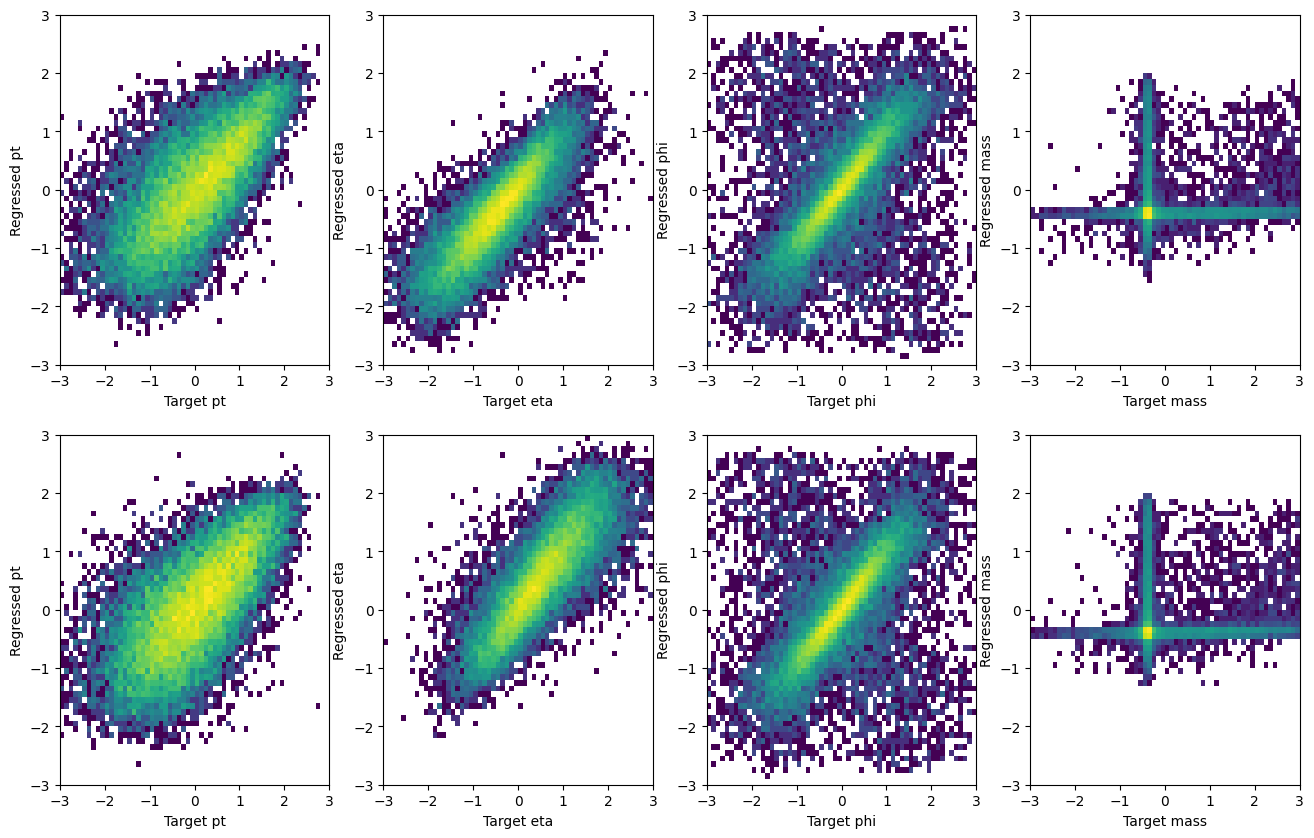

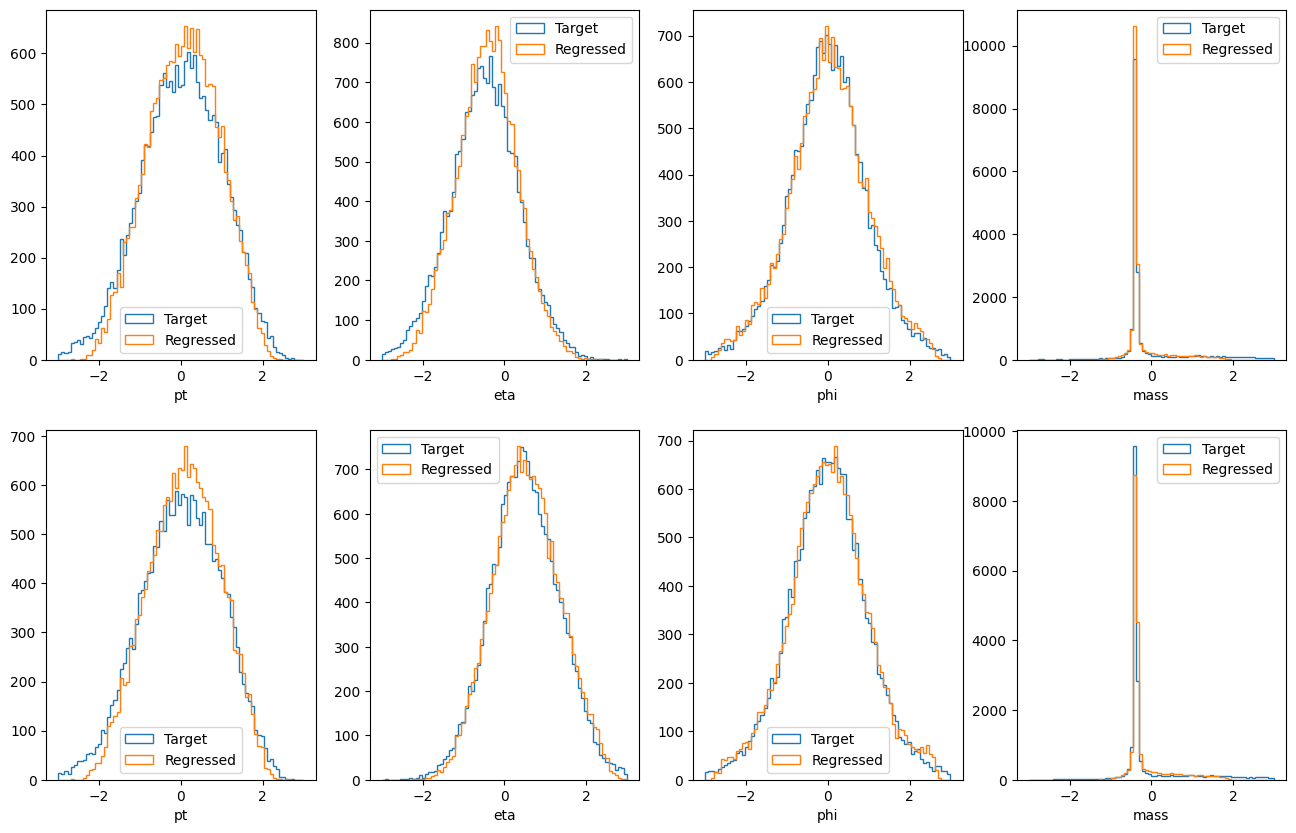

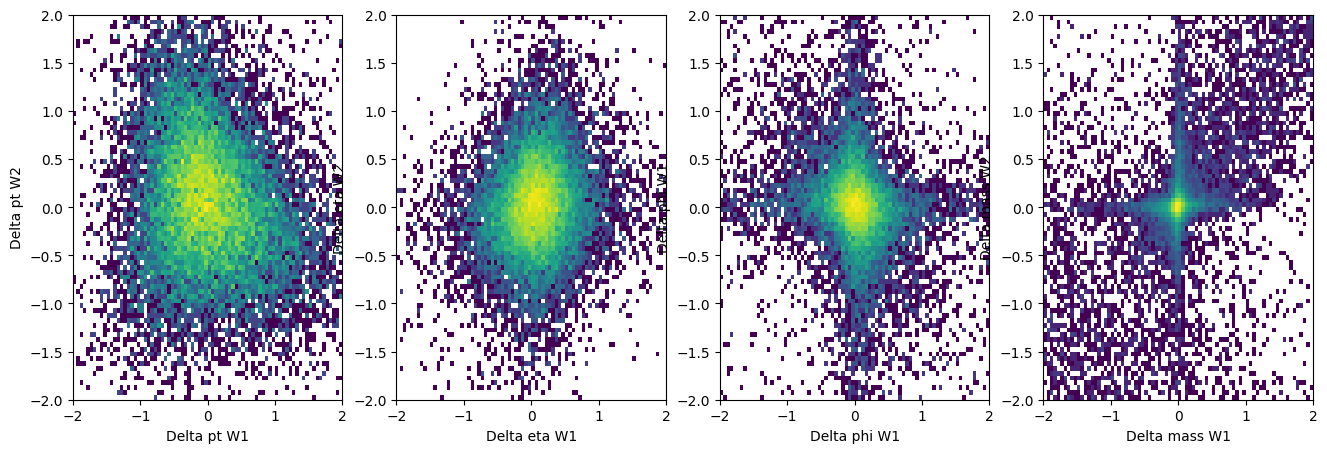

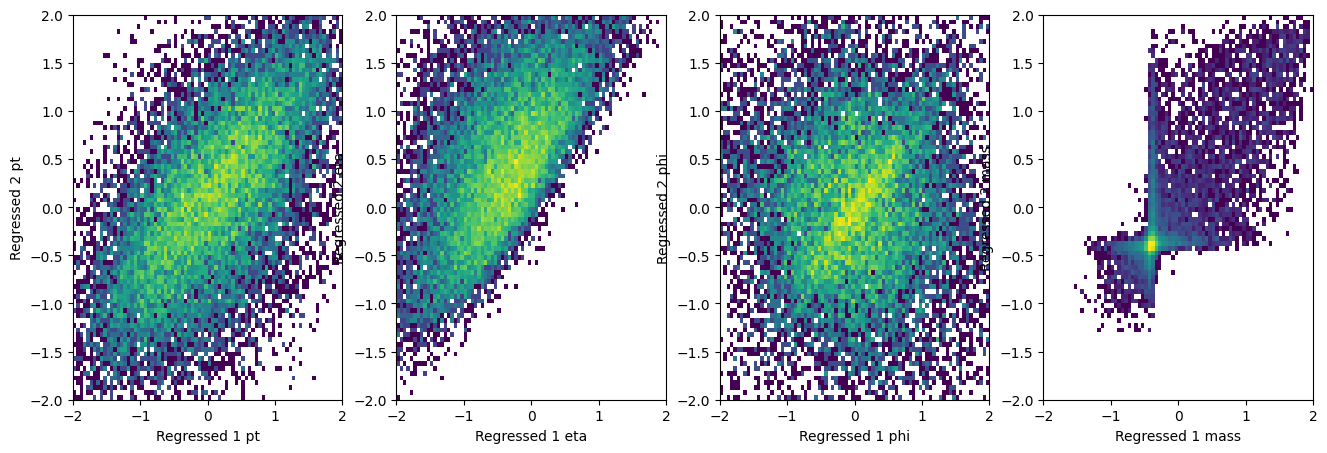

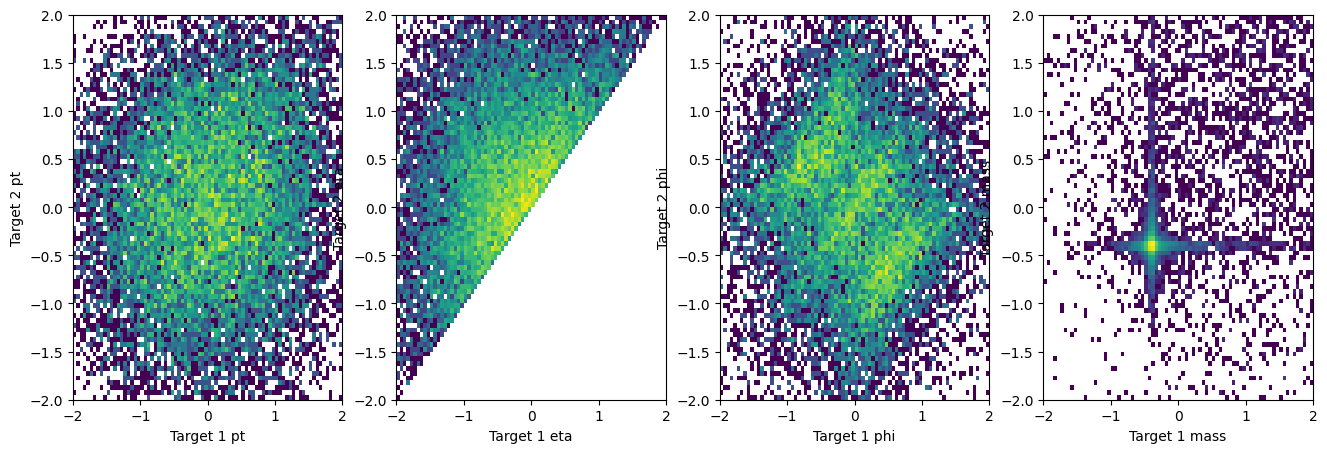

In [55]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)
    
validation_plots(W, W_out)

In [56]:
torch.save(model.state_dict(), "models/model_WWregr_mmd_phiperiodic_MDMMconstraints.pt")

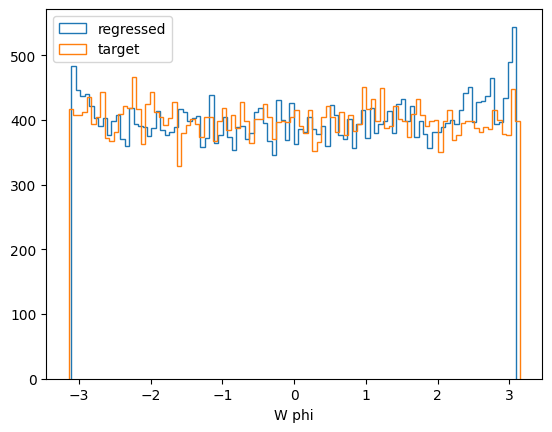

In [57]:
plt.hist(unscale_phi(W_out[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

After a longer training with stronger MMD constraint the phi distribution looks now nicer. 

# Comparison with a very simple DNN

It is interesting to compare the performance of the transformer with the one of a simple DNN trained from the same inputs and having 8 numbers as output (the W bosons four momenta). 